# Update LSTM model with new data

In [62]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pickle
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [63]:
# attention - it uses transform_and_split_data_update() function! not transform_and_split_data()
from different_functions import transform_and_split_data, denormalization, transform_and_split_data_update

### Data read and preparation

In [64]:
# GLOBAL 
# relh	 skph 	temp
df_train_and_test = pd.read_csv("lstm_models/mean_and_std")
training_mean = df_train_and_test['mean']
training_std = df_train_and_test['std']

In [65]:
# Read the CSV file - this is data from different station than this in learning module
all_data = pd.read_csv("data_for_main_model/data_ready_for_update.csv")
all_data.drop('Unnamed: 0',axis='columns', inplace=True)
# df = all_data[(all_data['year'] == 2022) & (all_data['month'] == 12) & ((all_data['day'] == 1) | (all_data['day'] == 2))]

In [66]:
# data for xgboost model
all_data_x = all_data.copy()
all_data_x.rename(columns ={'temp':'tmpc', 'skph':'sped'}, inplace=True)
all_data_x['hour'] = pd.to_datetime(all_data['time']).dt.hour
all_data_x.drop('time',axis='columns', inplace=True)
all_data_x.insert(loc=0, column="lat", value=51.7592) # Łódź
all_data_x.insert(loc=0, column="lon", value=19.4560) # Łódź
all_data_x.drop("minutes",axis='columns', inplace=True)

In [67]:
df = all_data[["relh", "skph", "temp"]]
df.head()
data = df.to_numpy()

### Update model with new data

In [68]:
def update_and_predict(LSTM_model, df_input, window_size = 12, timestamps_count = 0, learning_rate = 0.001, epochs = 10, size_of_timestamps = 168, how_many_updates = 10, is_update = True): # (size_of_timestamps = 168) == 7 days
 
    MAE_humid = []
    MAE_wind = []
    MAE_temp = []
    # fig, axs = plt.subplots(1)
    data = df_input.to_numpy()
    LSTM_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate= learning_rate), metrics=[RootMeanSquaredError()])
    LSTM_model.reset_states()
    for update in range(how_many_updates):
        data_patch_update = data[update * size_of_timestamps: (update+1) * size_of_timestamps + window_size + timestamps_count]
        X, y = transform_and_split_data_update(data_patch_update, training_mean, training_std, window_size, timestamps_count)
        # probe is data splitted in correct way #################
        vect = np.linspace(1,len(data_patch_update),len(data_patch_update))
        temp = [r[2] for r in data_patch_update[:]]
        # plt.plot(temp,vect+(update)*data_patch_update.shape[0])
        #########################################################
        data_patch_test = data[(update+1) * size_of_timestamps : (update+2) * size_of_timestamps + window_size + timestamps_count]
        X_test, y_test = transform_and_split_data_update(data_patch_test,training_mean, training_std, window_size, timestamps_count)

        # update model with new data
        if(is_update):
            LSTM_model.fit(X, y,  epochs=epochs, shuffle=False ,verbose = 0)
        else:
            LSTM_model.reset_states()
            
        # make predictions
        predictions = LSTM_model.predict(X_test)
        

        pred = []
        actual =[]
        features_len = y.shape[1]
        for i in range(features_len):
            pred.append(denormalization(predictions[:,i], training_mean[i], training_std[i]))
            actual.append(denormalization(y_test[:,i], training_mean[i], training_std[i]))
        # plot_predictions_and_actual(pred, actual)
        MAE_humid.append(mean_absolute_error(actual[0], pred[0]))
        MAE_wind.append(mean_absolute_error(actual[1], pred[1]))
        MAE_temp.append(mean_absolute_error(actual[2], pred[2]))

    # note: pred and actual are not normalized!
    return MAE_humid, MAE_wind, MAE_temp #, pred, actual

### Checking how huge should be data for each update and different epochs size

In [69]:
# checking how huge should be data for each update and different epochs - (5 is enough and 28 days for update is ok)

# for index in range(1,28): # from one to 28 days
#     model = pickle.load(open("lstm_models/lstm3.pkl", "rb", -1))
#     MAE_humid_nu, MAE_wind_nu, MAE_temp_nu = update_and_predict(model, df, 12, 5, 0.001, 5, 48*index, 10, False)
#     print("NU" + str(index)) 
#     print(np.mean(MAE_temp_nu))
#     for epoka in range(5,12):
#         model = pickle.load(open("lstm_models/lstm3.pkl", "rb", -1))
#         MAE_humid, MAE_wind, MAE_temp = update_and_predict(model, df, 12, 5, 0.001, epoka, 48*index, 10, True)
#         print(np.mean(MAE_temp))

In [70]:
# when size of data updating model 28

# not updated model
model = pickle.load(open("lstm_models/lstm_for_update3.pkl", "rb", -1))
MAE_humid_nu, MAE_wind_nu, MAE_temp_nu = update_and_predict(model, df, 12, 5, 0.001, 5, 48*28, 30, False)

# updated model
model = pickle.load(open("lstm_models/lstm_for_update3.pkl", "rb", -1))
MAE_humid, MAE_wind, MAE_temp = update_and_predict(model, df, 12, 5, 0.001, 5, 48*28, 30, True)

42/42 [==============================] - 0s 3ms/step


In [71]:
print(np.mean(MAE_temp_nu))
print(np.mean(MAE_temp))

2.3605161067748823
1.6759003097930598


# xGBoost

In [72]:
# def predict(xGBoost_model, df_input, window_size = 6, timestamps_count = 1, size_of_timestamps = 168, how_many_updates = 10): # (size_of_timestamps = 168) == 7 days
 
#     MAE_humid = []
#     MAE_wind = []
#     MAE_temp = []

#     # data = df_input.to_numpy()
#     for update in range(how_many_updates):
#         # data_patch_update = data[update * size_of_timestamps: (update+1) * size_of_timestamps + window_size + timestamps_count]
#         # X, y = transform_and_split_data(data_patch_update, window_size, timestamps_count)
#         data_patch_test = df_input[(update+1) * size_of_timestamps + window_size - 1: (update+2) * size_of_timestamps + window_size + timestamps_count]
#         X_test = data_patch_test[:-timestamps_count]
#         y_test = data_patch_test[timestamps_count:]

#         # # update model with new data
#         y_pred_xgb = xGBoost_model.predict(X_test)
#         y_pred_xgb = pd.DataFrame(y_pred_xgb, columns=[ "lon", "lat",  "tmpc",  "relh" ,"sped" ,"day","month", "year", "hour"])

#         # plot_predictions_and_actual(pred, actual)
#         MAE_humid.append(mean_absolute_error(y_pred_xgb[["relh"]],y_test[["relh"]]))
#         MAE_wind.append(mean_absolute_error(y_pred_xgb[["sped"]],y_test[["sped"]]))
#         MAE_temp.append(mean_absolute_error(y_pred_xgb[["tmpc"]],y_test[["tmpc"]]))

#     # note: pred and actual are not normalized!
#     return MAE_humid, MAE_wind, MAE_temp #, pred, actual

In [73]:
# model_x = pickle.load(open("xgb_models/xgb3.pkl", "rb", -1))
# MAE_humid_x, MAE_wind_x, MAE_temp_x = predict(model_x, all_data_x, 6, 3, 168, 140)

# Results

Text(0.5, 1.0, 'temp')

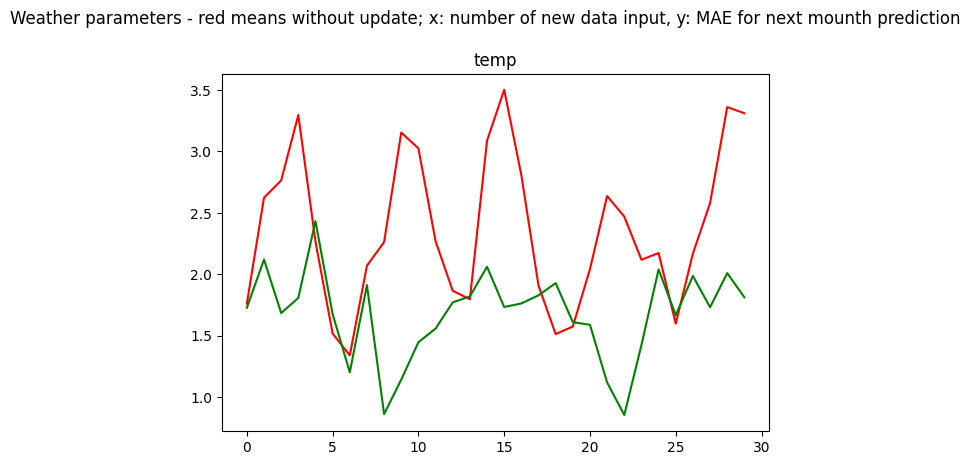

In [74]:
# TEMPERATURE
fig, axs = plt.subplots(1)
fig.suptitle('Weather parameters - red means without update; x: number of new data input, y: MAE for next mounth prediction')
fig.tight_layout(pad=1.8)
axs.plot(MAE_temp_nu,'r')
axs.plot(MAE_temp,'g')
axs.set_title('temp')

Text(0.5, 1.0, 'wind')

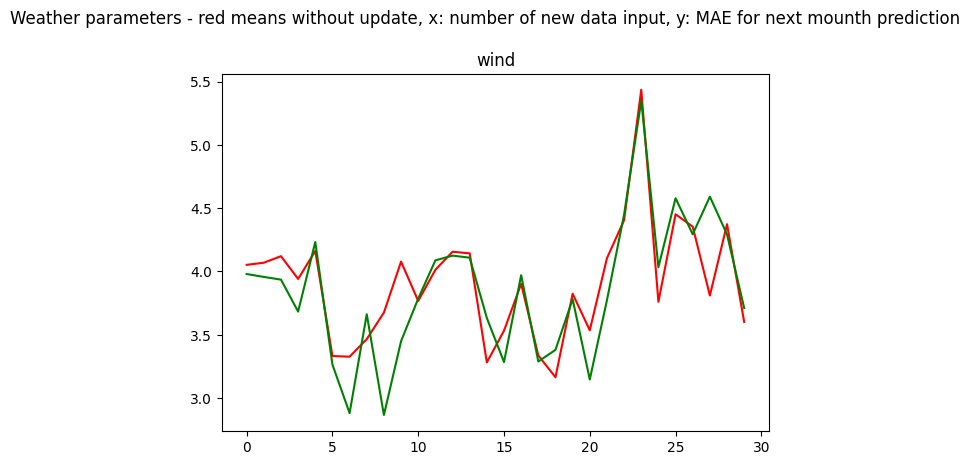

In [75]:
# WIND
fig, axs = plt.subplots(1)
fig.suptitle('Weather parameters - red means without update, x: number of new data input, y: MAE for next mounth prediction')
fig.tight_layout(pad=1.8)
axs.plot(MAE_wind_nu,'r')
axs.plot(MAE_wind,'g')
axs.set_title('wind')

Text(0.5, 1.0, 'humid')

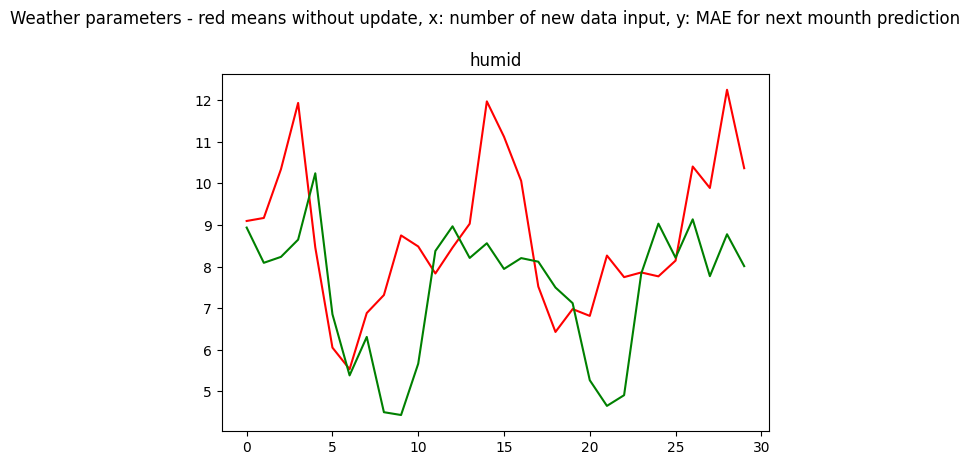

In [76]:
# HUMIDITY
fig, axs = plt.subplots(1)
fig.suptitle('Weather parameters - red means without update, x: number of new data input, y: MAE for next mounth prediction')
fig.tight_layout(pad=1.8)
axs.plot(MAE_humid_nu,'r')
axs.plot(MAE_humid,'g')
axs.set_title('humid')

# NOTES

### TODO
- prediction for next 7 days
- update with data from last 28 days

## in the future maybe:
- for different seasons different models
- or for different seasons different architectures! xgboost for (?) and LSTM for the rest